In [1]:
# JM: 04 Feb 2020
# do some basic statistical analysis on El Nino 3.4

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal

# open the text file and dump it out, then manipulate it into a usable form
f = open("elnino34.data", "r")
lines = []
for line in f:
    lines.append(line)
f.close()

In [2]:
# pull out the data as text and then turn it into an array
time, elnino34 = [], []
for i in range(3, len(lines) - 4): # read only stuff form 4th line to 4 lines before the end
    line = lines[i].split()
    j = 0
    for entry in line:
        if j == 0:
            time.append(int(entry))       # write it as an integer
        else:
            elnino34.append(float(entry)) # write it as a double float
        j += 1
time, elnino34 = np.asarray(time), np.asarray(elnino34)
n = len(elnino34)
time = np.linspace(time[0], time[-1] + 1, n + 1)[:-1:] # create the time-vector

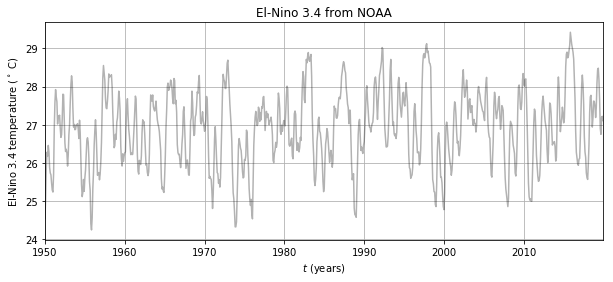

In [3]:
# 0) plot out the el-nino time-series
fig = plt.figure(figsize = (10, 4))
ax = plt.axes()
ax.plot(time, elnino34, 'k-', alpha = 0.3)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA")

fig.savefig("../figures/elnino34_time.png", dpi = 150)

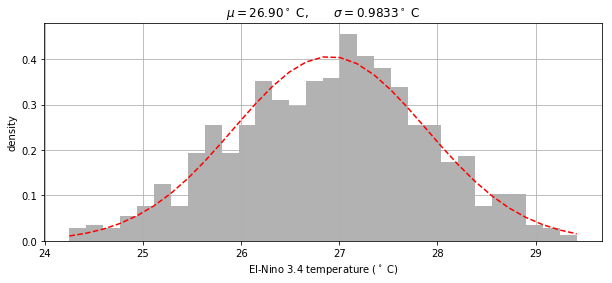

In [15]:
# 1) do some basic analysis on this
fig = plt.figure(figsize = (10, 4))
ax = plt.axes()

mu = np.mean(elnino34)
sigma = 0.0
for i in range(len(elnino34)):
    sigma += ((elnino34[i] - mu) ** 2) / len(elnino34)
sigma = np.sqrt(sigma)
count, bins, ignored = plt.hist(elnino34, 30, density = True, color = 'k', alpha = 0.3)
ax.plot(bins, 1.0 / (sigma * np.sqrt(2.0 * np.pi)) *
               np.exp( - (bins - mu) ** 2 / (2.0 * sigma ** 2) ), 'r--')

ax.grid()
ax.set_xlabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_ylabel(r"density")
ax.set_title(r"$\mu = %.2f {}^\circ\ \mathrm{C},\qquad \sigma = %.4f {}^\circ\ \mathrm{C}$" % (mu, sigma))

fig.savefig("../figures/elnino34_bar.png", dpi = 150)

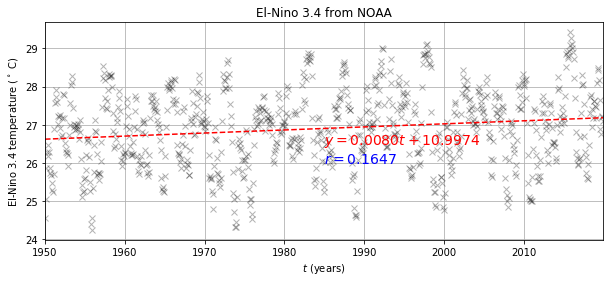

In [16]:
# 2) as data points and do a line of best-fit
#    calculate it explicitly
# mu_x, mu_y = np.mean(time), np.mean(elnino34)
# numer, denom = 0.0, 0.0
# for i in range(n):
#     numer += (time[i] - mu_x) * (elnino34[i] - mu_y)
#     denom += (time[i] - mu_x) ** 2
# m = numer / denom
# c = mu_y - (m * mu_x)

m, c, r, p, std_err = stats.linregress(time, elnino34)

fig = plt.figure(figsize = (10, 4))
ax = plt.axes()
ax.plot(time, elnino34, 'kx', alpha = 0.3)
ax.plot(time, m * time + c, 'r--')
ax.text(1985, 26.5, '$y = %.4f t + %.4f$' % (m, c), color = "r", fontsize = 14)
ax.text(1985, 26.0, '$r = %.4f$' % (r), color = "b", fontsize = 14)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA")

fig.savefig("../figures/elnino34_linreg.png", dpi = 150)

Text(0.5,1,'El-Nino 3.4 from NOAA (removed linear trend)')

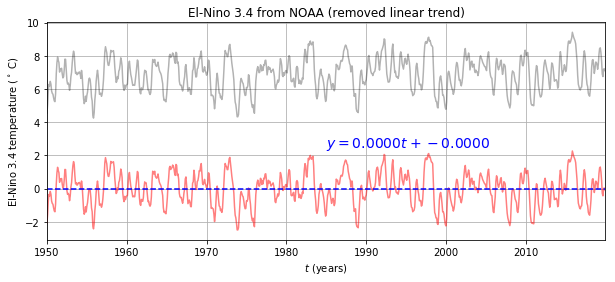

In [3]:
# 3) plot the detrended data

def detrend(time, data):
    # could use scipy.signal.detrend
    m, c, _, _, _ = stats.linregress(time, data)
    out_data = data - (m * time + c)
    
    return out_data
    
fig = plt.figure(figsize = (10, 4))
ax = plt.axes()
plt.plot(time, detrend(time, elnino34), 'r-', alpha = 0.5)
plt.plot(time, elnino34 - 20, 'k-', alpha = 0.3)

m_1, c_1, r_1, _, _ = stats.linregress(time, detrend(time, elnino34))
plt.plot(time, m_1 * time + c_1, 'b--')
ax.text(1985, 2.5, '$y = %.4f t + %.4f$' % (m_1, c_1), color = "b", fontsize = 14)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA (removed linear trend)")

fig.savefig("../figures/elnino34_detrend.png", dpi = 150)

/home/jclmak/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


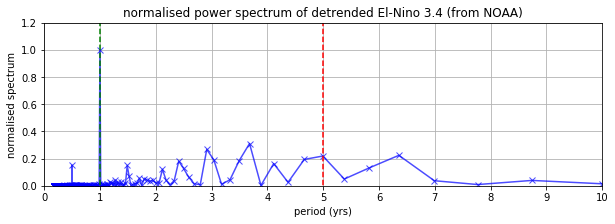

In [139]:
# 3) take a Fourier transform of the de-trended data (de-mean is probably ok)
#    and plot out the power-spectrum to pick out suggestions of oscillations
nt = len(elnino34)
enso34_hat = np.fft.fft(detrend(time,elnino34))
spectrum = np.abs(enso34_hat[0:int(nt/2)]) ** 2
spectrum /= np.max(spectrum)
frequency = np.arange(0, int(nt/2)) / (time[-1] - time[0])

fig = plt.figure(figsize= (10, 3))
ax = plt.subplot(1, 1, 1)
ax.plot(1.0 / frequency, spectrum, 'b-x', alpha = 0.7)
ax.plot([1, 1], [-2, 2], 'g--')
ax.plot([5, 5], [-2, 2], 'r--')

ax.grid()
ax.set_xlabel(r"period (yrs)")
ax.set_ylabel(r"normalised spectrum")
ax.set_title(r"normalised power spectrum of detrended El-Nino 3.4 (from NOAA)")
ax.set_xticks(np.arange(0, 11))
ax.set_xlim(0, 10)
ax.set_ylim(0, 1.2)

fig.savefig("../figures/elnino34_fft.png", dpi = 150)

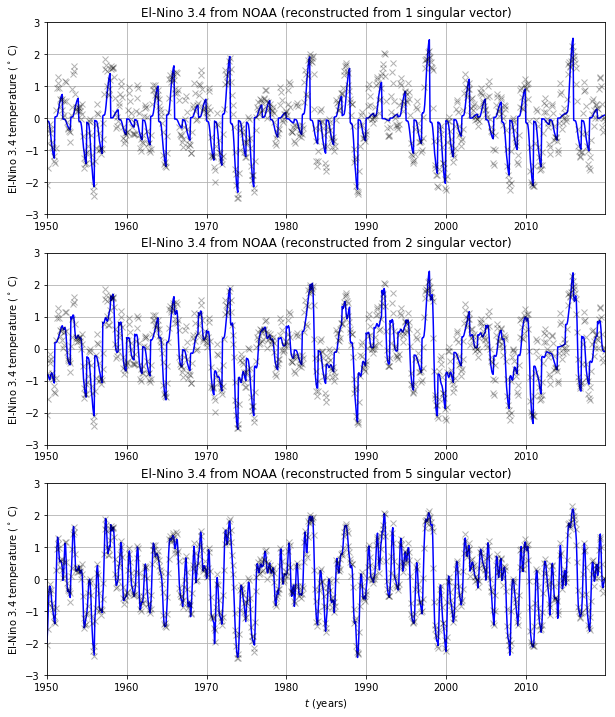

In [18]:
# 5) doing SVD on the reshaped data (somewhat artificial example)
#    normally we would have data(t, z, y, x) and rework it into array with t = rows, xyz= columns
#      i.e. array with a ton of columns
#    here we only have data(t) so this messes it around by reshaping it into
#      row = months, column = year, but need the reshaping needs a transpose
m = 70
test = detrend(time, elnino34).reshape((m, int(n / m))).transpose()
U, s, VT = np.linalg.svd(test, full_matrices=True)
S = np.zeros((test.shape[0], test.shape[1]))
S[:test.shape[0], :test.shape[0]] = np.diag(s)
n_component = 1
S = S[:, :n_component]
VT = VT[:n_component, :]
A = U.dot(S.dot(VT))

fig = plt.figure(figsize= (10, 12))
ax = plt.subplot(3, 1, 1)
ax.plot(time, A.transpose().reshape((n, 1)), 'b')
ax.plot(time, detrend(time,elnino34), 'kx', alpha = 0.3)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-3, 3)
# ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA (reconstructed from %i singular vector)" % n_component)

U, s, VT = np.linalg.svd(test, full_matrices=True)
S = np.zeros((test.shape[0], test.shape[1]))
S[:test.shape[0], :test.shape[0]] = np.diag(s)
n_component = 2
S = S[:, :n_component]
VT = VT[:n_component, :]
A = U.dot(S.dot(VT))

ax = plt.subplot(3, 1, 2)
ax.plot(time, A.transpose().reshape((n, 1)), 'b')
ax.plot(time, detrend(time,elnino34), 'kx', alpha = 0.3)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-3, 3)
# ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA (reconstructed from %i singular vector)" % n_component)

U, s, VT = np.linalg.svd(test, full_matrices=True)
S = np.zeros((test.shape[0], test.shape[1]))
S[:test.shape[0], :test.shape[0]] = np.diag(s)
n_component = 5
S = S[:, :n_component]
VT = VT[:n_component, :]
A = U.dot(S.dot(VT))

ax = plt.subplot(3, 1, 3)
ax.plot(time, A.transpose().reshape((n, 1)), 'b')
ax.plot(time, detrend(time,elnino34), 'kx', alpha = 0.3)

ax.grid()
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-3, 3)
ax.set_xlabel(r"$t$ (years)")
ax.set_ylabel(r"El-Nino 3.4 temperature (${}^\circ\ \mathrm{C}$)")
ax.set_title(r"El-Nino 3.4 from NOAA (reconstructed from %i singular vector)" % n_component)

fig.savefig("../figures/elnino34_svd.png", dpi = 150)